# Chapter 13

## Setup and Imports

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
nhefs_all = pd.read_excel('NHEFS.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [5]:
nhefs_all.shape

(1629, 64)

## Section 13.1

Subset the data as in the last chapter (though it's not necessary to restrict on all of these columns).

In [6]:
restriction_cols = [
    'sex', 'age', 'race', 'wt82', 'ht', 'school', 'alcoholpy', 'smokeintensity'
]
missing = nhefs_all[restriction_cols].isnull().any(axis=1)
nhefs = nhefs_all.loc[~missing]

In [7]:
nhefs.shape

(1566, 64)

## Section 13.2

In [8]:
table = nhefs.groupby('qsmk').agg({'qsmk': 'count'}).T
table.index = ['count']
table

qsmk,0,1
count,1163,403


### Program 13.1

Add squared features as in chapter 12

In [9]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs['{}^2'.format(col)] = nhefs[col] * nhefs[col]

Add constant term. We'll call it `'one'` this time.

In [10]:
nhefs['one'] = 1

A column of zeros will also be useful later

In [11]:
nhefs['zero'] = 0

Add dummy features

In [12]:
edu_dummies = pd.get_dummies(nhefs.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs.active, prefix='active')

nhefs = pd.concat(
    [nhefs, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

Add interaction term, new to this model

In [13]:
nhefs['qsmk_x_smokeintensity'] = nhefs.qsmk * nhefs.smokeintensity

Create model

In [14]:
y = nhefs.wt82_71
X = nhefs[[
    'one', 'qsmk', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2',
    'qsmk_x_smokeintensity'
]]

In [15]:
ols = sm.OLS(y, X) 
res = ols.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
one,-1.5882,4.313,-0.368,0.713,-10.048,6.872
qsmk,2.5596,0.809,3.163,0.002,0.972,4.147
sex,-1.4303,0.469,-3.050,0.002,-2.350,-0.510
race,0.5601,0.582,0.963,0.336,-0.581,1.701
edu_2,0.7904,0.607,1.302,0.193,-0.400,1.981
edu_3,0.5563,0.556,1.000,0.317,-0.534,1.647
edu_4,1.4916,0.832,1.792,0.073,-0.141,3.124
edu_5,-0.1950,0.741,-0.263,0.793,-1.649,1.259
exercise_1,0.2960,0.535,0.553,0.580,-0.754,1.346
exercise_2,0.3539,0.559,0.633,0.527,-0.742,1.450


Look at an example prediction, for the subject with ID 24770

In [16]:
example = X.loc[nhefs.seqn == 24770]

In [17]:
example

,one,qsmk,sex,race,edu_2,edu_3,edu_4,edu_5,exercise_1,exercise_2,...,active_2,age,age^2,wt71,wt71^2,smokeintensity,smokeintensity^2,smokeyrs,smokeyrs^2,qsmk_x_smokeintensity
1581,1,0,0,0,0,0,1,0,1,0,...,0,26,676,111.58,12450.0964,15,225,12,144,0


In [18]:
res.predict(example)

1581    0.342157
dtype: float64

A quick look at mean and extremes of the predicted weight gain, across subjects

In [19]:
estimated_gain = res.predict(X)

In [20]:
print('   min     mean      max')
print('------------------------')
print('{:>6.2f}   {:>6.2f}   {:>6.2f}'.format(
    estimated_gain.min(),
    estimated_gain.mean(),
    estimated_gain.max()
))

   min     mean      max
------------------------
-10.88     2.64     9.88


A quick look at mean and extreme values for actual weight gain

In [21]:
print('   min     mean      max')
print('------------------------')
print('{:>6.2f}   {:>6.2f}   {:>6.2f}'.format(
    nhefs.wt82_71.min(),
    nhefs.wt82_71.mean(),
    nhefs.wt82_71.max()
))

   min     mean      max
------------------------
-41.28     2.64    48.54


A scatterplot of predicted vs actual

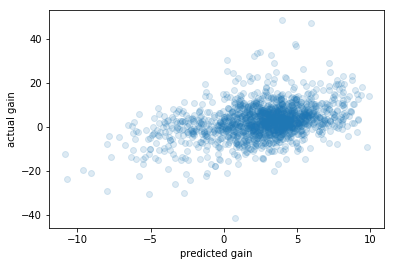

In [22]:
fix, ax = plt.subplots()

ax.scatter(estimated_gain, nhefs.wt82_71, alpha=0.15)
ax.set_xlabel('predicted gain')
ax.set_ylabel('actual gain');

## Section 13.3

### Program 13.2

The 4 steps to the method are
1. expansion of dataset
2. outcome modeling
3. prediction
4. standardization by averaging

I am going to use a few shortcuts. "Expansion of dataset" means creating the 3 blocks described in the text. The first block (the original data) is the only one that contributes to the model, so I'll just build the regression from the first block. The 2nd and 3rd blocks are only needed for predictions, so I'll only create them at prediction-time.

Thus my steps will look more like
1. outcome modeling, on the original data
2. prediction on expanded dataset
3. standardization by averaging

In [23]:
df = pd.DataFrame({
    'name': [
        "Rheia", "Kronos", "Demeter", "Hades", "Hestia", "Poseidon", 
        "Hera", "Zeus", "Artemis", "Apollo", "Leto", "Ares", "Athena", 
        "Hephaestus", "Aphrodite", "Cyclope", "Persephone", "Hermes", 
        "Hebe", "Dionysus"
    ],
    'L': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    'A': [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    'Y': [0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
})

df['A_x_L'] = df.A * df.L

df['zero'] = 0
df['one'] = 1

In [24]:
ols = sm.OLS(df.Y, df[['one', 'A', 'L', 'A_x_L']])
res = ols.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
one,0.2500,0.255,0.980,0.342,-0.291,0.791
A,4.441e-16,0.361,1.23e-15,1.000,-0.765,0.765
L,0.4167,0.390,1.069,0.301,-0.410,1.243
A_x_L,0,0.496,0,1.000,-1.051,1.051


Make predictions from the second block, with all A = 0, which also makes A x L = 0.

"the average of all predicted values in the second block is precisely the standardized mean in the untreated"

In [25]:
A0_pred = res.predict(df[['one', 'zero', 'L', 'zero']])
print('standardized mean: {:>0.2f}'.format(A0_pred.mean()))

standardized mean: 0.50


Make predictions from the third block, with all A = 1, which also makes A x L = L.

"To estimate the standardized mean outcome in the treated, we compute the average of all predicted values in the third block."

In [26]:
A1_pred = res.predict(df[['one', 'one', 'L', 'L']])
print('standardized mean: {:>0.2f}'.format(A1_pred.mean()))

standardized mean: 0.50


### Program 13.3

We repeat the steps done above, but for the `nhefs` data:

1. outcome modeling, on the original data
2. prediction on expanded dataset
3. standardization by averaging

Step 1: Outcome modeling on the `nhefs` data

Note: the model here, unlike in Program 13.1, does not have an interaction between `qsmk` and `smokeintensity`. Also, for convenience, I've moved `qsmk` to the end of the variable list.

In [27]:
y = nhefs.wt82_71
X = nhefs[[
    'one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2',
    'qsmk'
]]

In [28]:
ols = sm.OLS(y, X) 
res = ols.fit()

Step 2: Prediction on expanded dataset

In [29]:
block2 = nhefs[[
    'one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2',
    'zero'  # qsmk = 0
]]

In [30]:
block2_pred = res.predict(block2)

In [31]:
block3 = nhefs[[
    'one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2',
    'one'  # qsmk = 1
]]

In [32]:
block3_pred = res.predict(block3)

Step 3: Standardization by averaging

In [33]:
block2_mean = block2_pred.mean()
block3_mean = block3_pred.mean()
est_diff = block3_mean - block2_mean

print('block 2 mean prediction: {:>0.2f}'.format(block2_mean))
print('block 3 mean prediction: {:>0.2f}'.format(block3_mean))
print(' causal effect estimate: {:>0.2f}'.format(est_diff))

block 2 mean prediction: 1.75
block 3 mean prediction: 5.21
 causal effect estimate: 3.46


### Program 13.4

Use bootstrap to calculate the confidence interval on the previous estimate

If this runs too slowly, you can reduce the number of iterations in the `for` loop

In [34]:
boot_samples = []
common_X = [
    'one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2'
]

for _ in range(2000):
    sample = nhefs.sample(n=nhefs.shape[0], replace=True)
    
    y = sample.wt82_71
    X = sample[common_X + ['qsmk']]
    block2 = sample[common_X + ['zero']]
    block3 = sample[common_X + ['one']]
    
    result = sm.OLS(y, X).fit()
    
    block2_pred = result.predict(block2)
    block3_pred = result.predict(block3)
    
    boot_samples.append(block3_pred.mean() - block2_pred.mean())

In [35]:
std = np.std(boot_samples)

In [36]:
lo = est_diff - 1.96 * std
hi = est_diff + 1.96 * std

print('               estimate   95% C.I.')
print('causal effect   {:>6.1f}   ({:>0.1f}, {:>0.1f})'.format(est_diff, lo, hi))

               estimate   95% C.I.
causal effect      3.5   (2.5, 4.4)


This confidence interval can be slightly different from the book values, because of bootstrap randomness